In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import datetime as dt

## Dataset

In [2]:
train_set = pd.read_csv('final_dataset.csv' , index_col = 0 )
test_set = pd.read_csv('testdata_210911.csv')   #prophet

In [3]:
test_set['year'] = pd.to_datetime(test_set.base_date).dt.year
test_set['month'] = pd.to_datetime(test_set.base_date).dt.month
test_set['date'] = pd.to_datetime(test_set.base_date).dt.day

In [4]:
test_set =test_set[['year', 'month', 'date','emd_nm', 'card_use_cnt', 'delivery_per_cnt',
       'market_per_cnt', 'visit_ratio', 'frgn_ratio', 'youth_ratio',
       'total_pop', '제주_resd_ratio', '제주_resd_pop']]

### 건입동만 해보기

In [25]:
i = train_set.emd_nm.unique()[0]

In [26]:
# 데이터셋 feature/train으로 분리 후 train/test셋으로 분리하기
data = train_set[train_set.emd_nm == i]
test_data = test_set[test_set.emd_nm == i]

feature_df = data.drop(['em_g','emd_nm'],axis =1)
X_test= test_data.drop( 'emd_nm', axis =1)
target_df = data[['em_g']]

# train/ valid로 분할
X_train, X_valid, y_train, y_valid = train_test_split(feature_df, target_df, test_size = 0.3, random_state = 45)


array([[<AxesSubplot:title={'center':'em_g'}>]], dtype=object)

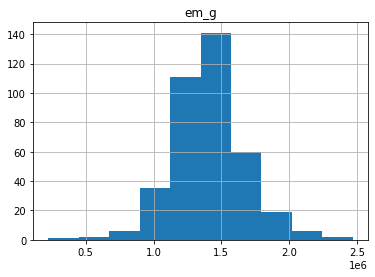

In [27]:
y_valid.hist()

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'date'}>],
       [<AxesSubplot:title={'center':'total_pop'}>,
        <AxesSubplot:title={'center':'제주_resd_ratio'}>,
        <AxesSubplot:title={'center':'제주_resd_pop'}>],
       [<AxesSubplot:title={'center':'visit_ratio'}>,
        <AxesSubplot:title={'center':'card_use_cnt'}>,
        <AxesSubplot:title={'center':'delivery_per_cnt'}>],
       [<AxesSubplot:title={'center':'market_per_cnt'}>,
        <AxesSubplot:title={'center':'frgn_ratio'}>,
        <AxesSubplot:title={'center':'youth_ratio'}>]], dtype=object)

c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)


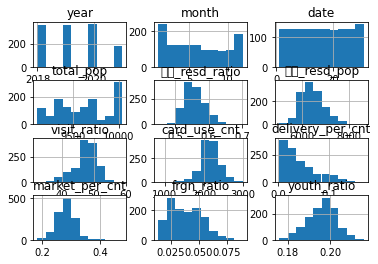

In [7]:
feature_df.hist()

In [8]:
# scailing 

# 중앙값 0 / IQR 1
scaler = RobustScaler()

scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_valid = scaler.transform(X_valid)
X_scaled_test = scaler.transform(X_test)

X_scaled_train = pd.DataFrame(X_scaled_train , index = X_train.index , columns = X_train.columns)
X_scaled_valid = pd.DataFrame(X_scaled_valid , index = X_valid.index , columns = X_valid.columns)
X_scaled_test = pd.DataFrame(X_scaled_test , index = X_test.index , columns = X_test.columns)


In [9]:
# 선형회귀 모델 구축

lr = LinearRegression().fit(X_scaled_train, y_train)

print("train set score: ", lr.score(X_scaled_train, y_train))
print("valid set score: ", lr.score(X_scaled_valid, y_valid))

train set score:  0.4526856725693339
valid set score:  0.3983084851467843


In [10]:
# Ordinary Least Sqaure regression
def ols(train_x, train_y, valid_x, valid_y):
    linreg = LinearRegression(n_jobs=-1)
    linreg_fit = linreg.fit(train_x, train_y)
    pred = linreg.predict(valid_x)
    
    r_squared = linreg.score(train_x, train_y)
    rmse = np.sqrt(np.mean((pred-valid_y).values**2))
    
    return pred, r_squared, rmse, linreg

valid_pred_y, train_r_squared, rmse , linreg = ols(X_scaled_train, y_train, X_scaled_valid, y_valid)

In [11]:
# OLS result
print('R squared :', train_r_squared)
print('RMSE :', rmse)

R squared : 0.4526856725693339
RMSE : 208194.43614863456


c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


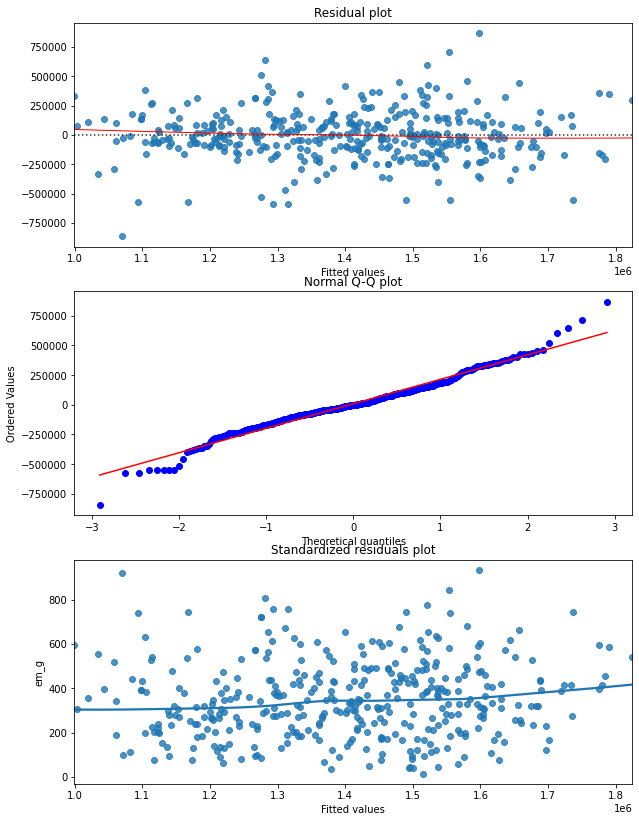

In [13]:
# plot

def plot_resd_assump(y_valid_pred , y_valid): 
     
        plt.figure(figsize = (10,14))

        plt.subplot(3,1,1)
        sns.residplot(y_valid_pred.reshape(-1), y_valid.values.reshape(-1), lowess = True , 
                      line_kws={'color':'red' , 'lw': 1, 'alpha':1})
        plt.xlabel('Fitted values')
        plt.title('Residual plot')

        residual = y_valid.iloc[:,0] - y_valid_pred.reshape(-1)

        plt.subplot(3,1,2)
        stats.probplot(residual, dist='norm', plot=plt)
        plt.title('Normal Q-Q plot')


        standardized_residual = np.sqrt(np.abs(residual))

        plt.subplot(3,1,3)
        sns.regplot(y_valid_pred.reshape(-1) , standardized_residual, scatter = True, lowess = True)
        plt.xlabel('Fitted values')
        plt.title('Standardized residuals plot')

        plt.show()
        
plot_resd_assump(valid_pred_y, y_valid)

### 읍면동 Encoding

#### 이상치, scailing없이 그냥 해보기

In [14]:
print(train_set.emd_nm.unique())
print(test_set.emd_nm.unique())

['건입동' '남원읍' '노형동' '대륜동' '대정읍' '대천동' '도두동' '동홍동' '봉개동' '삼도1동' '삼도2동' '삼양동'
 '서홍동' '성산읍' '송산동' '아라동' '안덕면' '애월읍' '연동' '영천동' '예래동' '오라동' '외도동' '용담1동'
 '용담2동' '이도1동' '이도2동' '이호동' '일도1동' '일도2동' '정방동' '중문동' '중앙동' '천지동' '표선면'
 '화북동' '효돈동' '전체' '조천읍' '구좌읍' '한림읍' '한경면']
['건입동' '남원읍' '노형동' '대륜동' '대정읍' '대천동' '도두동' '동홍동' '봉개동' '삼도1동' '삼도2동' '삼양동'
 '서홍동' '성산읍' '송산동' '아라동' '안덕면' '애월읍' '연동' '영천동' '예래동' '오라동' '외도동' '용담1동'
 '용담2동' '이도1동' '이도2동' '이호동' '일도1동' '일도2동' '정방동' '중문동' '중앙동' '천지동' '표선면'
 '화북동' '효돈동' '전체' '조천읍' '구좌읍' '한림읍' '한경면']


In [30]:
# sklearn 에서 레이블 인코더 불러오기
from sklearn import preprocessing

# 레이블 인코더 객체 저장
label_encoder = preprocessing.LabelEncoder()

#읍면동 컬럼 이노딩
train_set['emd_nm'] = label_encoder.fit_transform(train_set['emd_nm'])
test_set['emd_nm'] = label_encoder.fit_transform(test_set['emd_nm'])


In [31]:
print(train_set.emd_nm.unique())
print(test_set.emd_nm.unique())

[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 34 35 36 37 40 41 31 33  1 39 38]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 34 35 36 37 40 41 31 33  1 39 38]


In [ ]:
# data train/valid/test 으로 분리

feature_df = train_set_clean.drop(['em_g'],axis =1)
# X_test= test_set

target_df = train_set_clean[['em_g']]

# train/ valid로 분할
X_train, X_valid, y_train, y_valid = train_test_split(feature_df, target_df, test_size = 0.3, random_state = 45)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
# print(X_test.shape)

In [ ]:
# 선형회귀 모델 구축

lr = LinearRegression().fit(X_train, y_train)

print("train set score: ", lr.score(X_train, y_train))
print("valid set score: ", lr.score(X_valid, y_valid))

In [ ]:
# Ordinary Least Sqaure regression
def ols(X_train, y_train, X_valid, y_valid):
    linreg = LinearRegression(n_jobs=-1)
    linreg_fit = linreg.fit(X_train, y_train)
    pred = linreg.predict(X_valid)
    
    r_squared = linreg.score(X_train, y_train)
    rmse = np.sqrt(np.mean((pred-y_valid).values**2))
    
    return pred, r_squared, rmse, linreg

valid_fcst_y, r_squared, rmse , linreg = ols(X_train, y_train, X_valid, y_valid)

In [ ]:
# OLS result
print('R squared :', r_squared)
print('RMSE :', rmse)

In [ ]:
# plot

plot_resd_assump(valid_fcst_y, y_valid)

#### 이상치 제거하고 scailing 없이

c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)


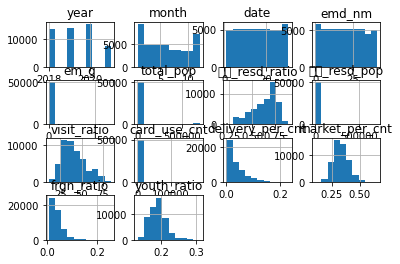

In [65]:
# 이상치 제거

# 이상치 확인

train_set.hist()

# em_g, total_pop, resd_pop, card_use_cnt
# delivery_per_cnt, frgn_ratio


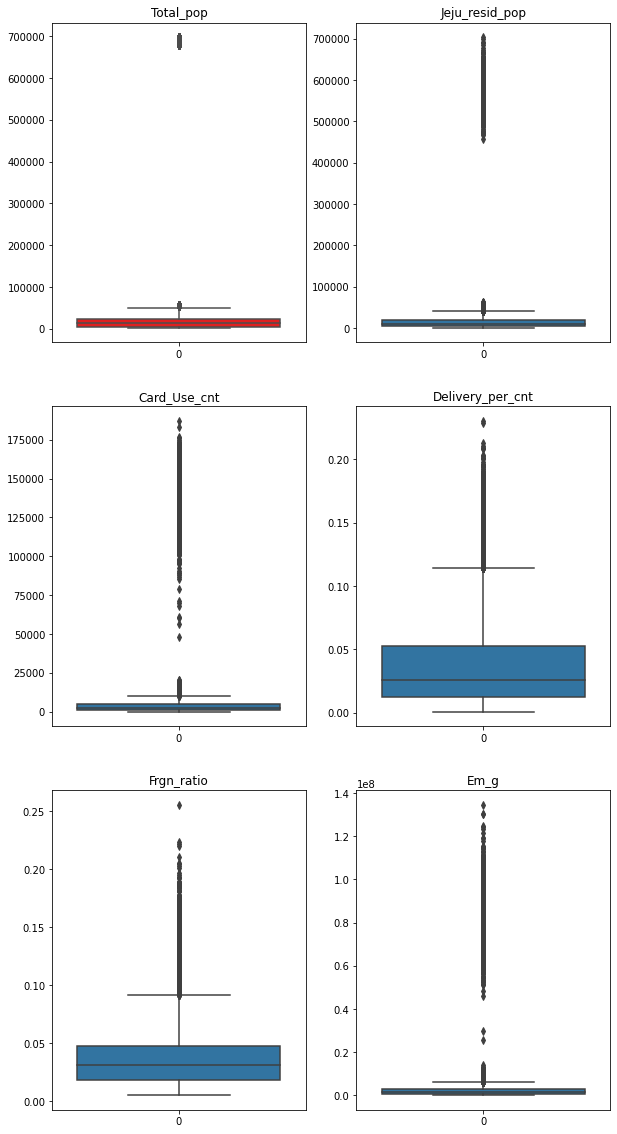

In [63]:
# box plot

plt.figure(figsize = (10,20))
plt.subplot(3,2,1)
sns.boxplot(data = train_set['total_pop'],color = 'red')
plt.title('Total_pop')


plt.subplot(3,2,2)
sns.boxplot(data= train_set['제주_resd_pop'])
plt.title("Jeju_resid_pop")

plt.subplot(3,2,3)
sns.boxplot(data = train_set['card_use_cnt'])
plt.title('Card_Use_cnt')

plt.subplot(3,2,4)
sns.boxplot(data= train_set['delivery_per_cnt'])
plt.title('Delivery_per_cnt')

plt.subplot(3,2,5)
sns.boxplot(data= train_set['frgn_ratio'])
plt.title('Frgn_ratio')

plt.subplot(3,2,6)
sns.boxplot(data= train_set['em_g'])
plt.title('Em_g')

plt.show()

c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='em_g', ylabel='Density'>

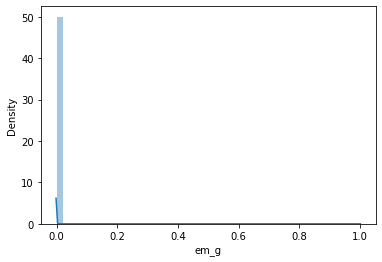

In [69]:
# skewness 확인

train_set['em_g'].skew()
#KDE plot
sns.distplot(train_set['em_g'])

In [74]:
# 이상치 제거

def outliers_iqr(data):
    q1,q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    lower_bound = q1-(iqr*1.5)
    upper_bound = q3 + (iqr*1.5)
    
    return np.where((data>upper_bound)|(data<lower_bound))

In [112]:
total_pop_outlier_index = outliers_iqr(train_set['total_pop'])[0]
resd_pop_outlier_index = outliers_iqr(train_set['제주_resd_pop'])[0]
card_use_cnt_outlier_index = outliers_iqr(train_set['card_use_cnt'])[0]
delivery_per_cnt_outlier_index = outliers_iqr(train_set['delivery_per_cnt'])[0]
frgn_ratio_outlier_index = outliers_iqr(train_set['frgn_ratio'])[0]

em_g_outlier_index = outliers_iqr(train_set['em_g'])[0]

print(train_set.loc[total_pop_outlier_index , 'total_pop'])
print(train_set.loc[resd_pop_outlier_index , '제주_resd_pop'])
print(train_set.loc[card_use_cnt_outlier_index , 'card_use_cnt'])
print(train_set.loc[delivery_per_cnt_outlier_index , 'delivery_per_cnt'])
print(train_set.loc[frgn_ratio_outlier_index , 'frgn_ratio'])

print(train_set.loc[em_g_outlier_index , 'em_g'])

2         54958
37       679922
40        54958
75       679922
78        54958
          ...  
50803    696950
50807     57473
50844    696950
50848     57473
50885    696950
Name: total_pop, Length: 2554, dtype: int64
2         50660.687565
18        44803.301450
26        50527.038778
37       535888.570169
40        51364.794657
             ...      
50848     52514.972173
50861     42414.120501
50864     44711.403016
50872     48630.062228
50885    576750.852147
Name: 제주_resd_pop, Length: 5230, dtype: float64
2         12507.0
26        10783.0
37       108983.0
40        12255.0
75       107164.0
           ...   
50844    142605.0
50848     16007.0
50864     12663.0
50872     12675.0
50885    143124.0
Name: card_use_cnt, Length: 4815, dtype: float64
28434    0.128391
29086    0.119186
29634    0.129870
30514    0.166667
31230    0.134328
           ...   
50871    0.158530
50872    0.127416
50873    0.141636
50875    0.121043
50879    0.119760
Name: delivery_per_cnt, Length: 21

In [114]:
# 이상치 index concat

lead_outlier_index = np.concatenate((total_pop_outlier_index,
                                     resd_pop_outlier_index,
                                     card_use_cnt_outlier_index,
                                     delivery_per_cnt_outlier_index,
                                     frgn_ratio_outlier_index,
                                    em_g_outlier_index), axis = None)

print(len(lead_outlier_index))
lead_outlier_index

20894


array([    2,    37,    40, ..., 50848, 50872, 50885], dtype=int64)

In [115]:
# 이상치가 아닌 index를 이용ㅎ애 leaad_not_outlier_index

lead_not_outlier_index = []

for i in train_set.index :
    if i not in lead_outlier_index:
        lead_not_outlier_index.append(i)

In [116]:
train_set_clean = train_set.loc[lead_not_outlier_index]
train_set_clean = train_set_clean.reset_index(drop=True)
train_set_clean

,year,month,date,emd_nm,em_g,total_pop,제주_resd_ratio,제주_resd_pop,visit_ratio,card_use_cnt,delivery_per_cnt,market_per_cnt,frgn_ratio,youth_ratio
0,2018,1,1,0,1708250,10028,0.552623,7274.890502,49.642958,1806.0,0.002769,0.326135,0.038427,0.200261
1,2018,1,1,2,1239600,19740,0.704247,12143.821692,41.452047,1581.0,0.015813,0.294750,0.025900,0.177984
2,2018,1,1,4,1717700,13651,0.667224,11185.575639,42.502310,2032.0,0.009843,0.422736,0.014440,0.208504
3,2018,1,1,5,1264950,22603,0.784751,16075.181182,28.652628,1973.0,0.017233,0.437912,0.053508,0.168114
4,2018,1,1,6,1765600,13404,0.616345,6460.308580,47.850066,2009.0,0.004978,0.393728,0.021953,0.203902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42523,2021,6,30,37,1377450,12681,0.767787,10137.380983,37.654521,1336.0,0.056138,0.316617,0.018484,0.172624
42524,2021,6,30,38,973850,9495,0.749118,7257.895822,35.350145,1286.0,0.031104,0.328927,0.042559,0.171578
42525,2021,6,30,39,3298100,24462,0.769060,20632.727912,35.614095,3044.0,0.084428,0.219777,0.048140,0.197206
42526,2021,6,30,40,3749600,24630,0.705806,24117.268821,27.871984,5644.0,0.114103,0.291460,0.010642,0.167519


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'emd_nm'}>],
       [<AxesSubplot:title={'center':'em_g'}>,
        <AxesSubplot:title={'center':'total_pop'}>,
        <AxesSubplot:title={'center':'제주_resd_ratio'}>,
        <AxesSubplot:title={'center':'제주_resd_pop'}>],
       [<AxesSubplot:title={'center':'visit_ratio'}>,
        <AxesSubplot:title={'center':'card_use_cnt'}>,
        <AxesSubplot:title={'center':'delivery_per_cnt'}>,
        <AxesSubplot:title={'center':'market_per_cnt'}>],
       [<AxesSubplot:title={'center':'frgn_ratio'}>,
        <AxesSubplot:title={'center':'youth_ratio'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)


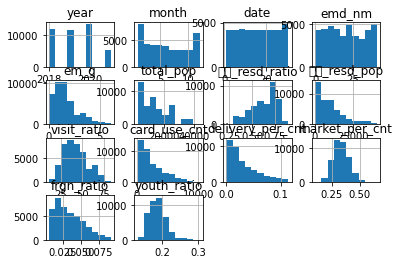

In [117]:
train_set_clean.hist()

In [88]:
# data train/valid/test 으로 분리

feature_df = train_set_clean.drop(['em_g'],axis =1)
# X_test= test_set

target_df = train_set_clean[['em_g']]

# train/ valid로 분할
X_train, X_valid, y_train, y_valid = train_test_split(feature_df, target_df, test_size = 0.3, random_state = 45)

In [89]:
print(X_train.shape)
print(X_valid.shape)
# print(X_test.shape)

(29915, 13)
(12821, 13)


In [90]:
# 선형회귀 모델 구축

lr = LinearRegression().fit(X_train, y_train)

print("train set score: ", lr.score(X_train, y_train))
print("valid set score: ", lr.score(X_valid, y_valid))

train set score:  0.7171160224977211
valid set score:  0.7021306589112231


In [91]:
# Ordinary Least Sqaure regression
def ols(X_train, y_train, X_valid, y_valid):
    linreg = LinearRegression(n_jobs=-1)
    linreg_fit = linreg.fit(X_train, y_train)
    pred = linreg.predict(X_valid)
    
    r_squared = linreg.score(X_train, y_train)
    rmse = np.sqrt(np.mean((pred-y_valid).values**2))
    
    return pred, r_squared, rmse, linreg

valid_fcst_y, r_squared, rmse , linreg = ols(X_train, y_train, X_valid, y_valid)

In [92]:
# OLS result
print('R squared :', r_squared)
print('RMSE :', rmse)

R squared : 0.7171160224977211
RMSE : 662556.7590845339


c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


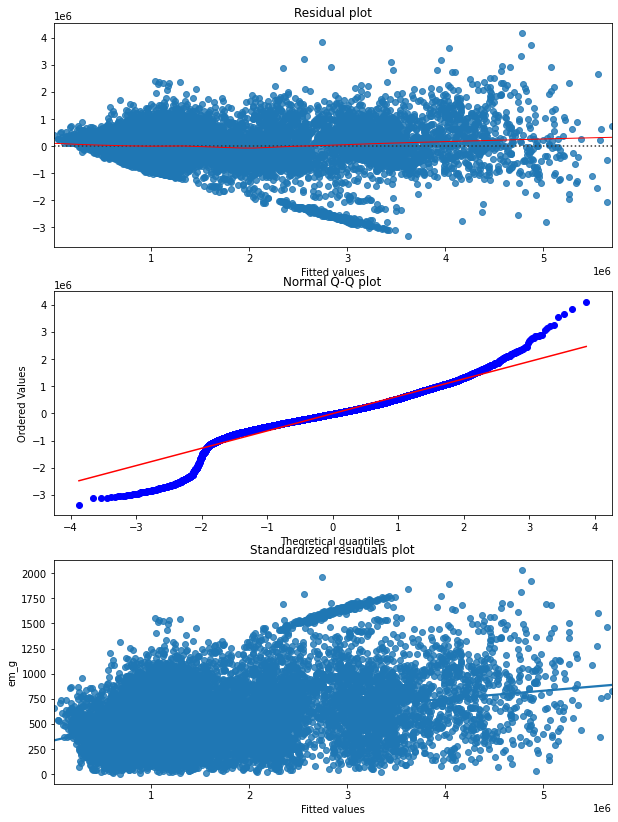

In [93]:
# plot

plot_resd_assump(valid_fcst_y, y_valid)

#### 이상치제거하고 scaliing 하기

In [118]:
# data train/valid/test 으로 분리

feature_df = train_set_clean.drop(['em_g'],axis =1)
# X_test= test_set

target_df = train_set_clean[['em_g']]

# train/ valid로 분할
X_train, X_valid, y_train, y_valid = train_test_split(feature_df, target_df, test_size = 0.3, random_state = 45)


# 독립변수 scaling

def scaliing(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    dataframe_scaled= pd.DataFrame(data_scaled, index = data.index , columns = data.columns)
    
    return dataframe_scaled, scaler

X_train_scaled, X_train_scaler = scaliing(X_train)
X_valid_scaled = pd.DataFrame(X_train_scaler.transform(X_valid), index = X_valid.index, columns = X_valid.columns)


In [119]:
# Ordinary Least Sqaure regression
def ols(X_train, y_train, X_valid, y_valid):
    linreg = LinearRegression(n_jobs=-1)
    linreg_fit = linreg.fit(X_train, y_train)
    pred = linreg.predict(X_valid)
    
    r_squared = linreg.score(X_train, y_train)
    rmse = np.sqrt(np.mean((pred-y_valid).values**2))
    
    return pred, r_squared, rmse, linreg

valid_fcst_y, r_squared, rmse , linreg = ols(X_train, y_train, X_valid, y_valid)

In [120]:
# OLS result
print('R squared :', r_squared)
print('RMSE :', rmse)

R squared : 0.707716839675556
RMSE : 635327.9813050805


c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\userk\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


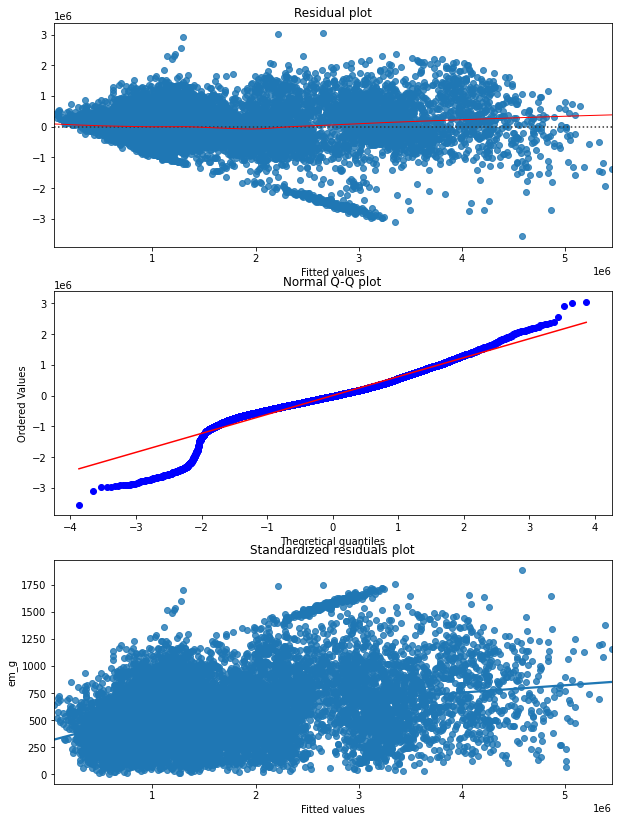

In [121]:
# plot

plot_resd_assump(valid_fcst_y, y_valid)